In [12]:
from datetime import datetime
import random
import networkx as nx
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt
from networkx.classes.function import path_weight
from networkx.drawing.nx_agraph import graphviz_layout
import pulp
import itertools

simulating = True
numero_de_nodos = [5,10,20,50,100,150,200]   #or simulations
numero_de_soluciones = []
avg_con = []
iter_nodos = 0
desired_degree = 4.0
sim_iterations = 100
numero_medio_sol_sist_1sensor = []
numero_medio_sol_sist_2sensores = []
error_estandar_sistemas_1_sensor = []
error_estandar_sistemas_2_sensores = []
tam_bipartito = []
camino_mas_largo = []
prom_tam_bipartito = []
prom_camino_mas_largo = []

########################################################################################
start_time = datetime.now()
########################################################################################

while simulating:
    nnodos = numero_de_nodos[iter_nodos]
    # Generate an Erdős-Rényi graph with n nodes and edge probability p
    n = nnodos
    p = desired_degree / (n-1)
    graph = nx.erdos_renyi_graph(n, p)

    # Turn the graph into an acyclic graph
    acyclic_graph = nx.DiGraph()

    # Copy nodes from original graph to acyclic graph
    for node in graph.nodes():
        acyclic_graph.add_node(node)

    # Copy edges from original graph to acyclic graph
    for edge in graph.edges():
        # Check if adding this edge creates a cycle
        acyclic_graph.add_edge(edge[0], edge[1])
        if nx.is_directed_acyclic_graph(acyclic_graph):
            continue
        else:
            # If adding the edge creates a cycle, remove it
            acyclic_graph.remove_edge(edge[0], edge[1])

    Gk = acyclic_graph.to_undirected()
    subgraphs = [Gk.subgraph(c) for c in nx.connected_components(Gk)]
    if len(subgraphs) > 1:
        contad = 0
        bool_a = True

        while bool_a == True and contad < len(subgraphs):
            for n, i in enumerate(subgraphs):
                bool_b = True
                contad += 1
                if n+1 < len(subgraphs):
                    lista_de_nodos = list(subgraphs[n+1].nodes())
                    sub_gi_nodes = list(i.nodes())
                    j = random.sample(sub_gi_nodes, 1)
                    while bool_b == True:
                        s1 = random.sample(lista_de_nodos, 1)
                        if not nx.has_path(Gk, s1[0], j[0]):
                            Gk.add_edge(j[0], s1[0])
                            bool_b = False
                        if nx.has_path(Gk, s1[0], j[0]):
                            lista_de_nodos.remove(s1[0])  
                        if len(lista_de_nodos) == 0:
                            lista_de_nodos = list(subgraphs[n+1].nodes())
                            sub_gi_nodes.remove(j[0])
                            if len(sub_gi_nodes) == 0:
                                bool_a = False
                                break
                            j = random.sample(sub_gi_nodes, 1)

                if nx.is_connected(Gk):
                    bool_a = False
                    break

            G_new = Gk.to_directed()
            #and G_new.in_degree(j[0]) >= G_new.in_degree(i[0]):
            edges_to_delete = []
            for i in list(G_new.edges()):
                for j in list(G_new.edges()):
                    if i[0] == j[1] and i[1] == j[0] and i not in edges_to_delete:
                        edges_to_delete.append(j)
            G_new.remove_edges_from(edges_to_delete)

    if len(subgraphs) > 1:
        G = G_new.copy()
    if len(subgraphs) == 1:
        G = acyclic_graph.copy()
    
    assert nx.is_directed_acyclic_graph(G) == True
    assert nx.is_weakly_connected(G) == True
    # Print information about the graph
    #print("Generated graph with {} nodes and {} edges".format(G.number_of_nodes(), G.number_of_edges()))
    #print('\n')

    degrees = []
    suma = 0
    avg = 0
    for i in G.nodes():
        degrees.append(G.degree(i))
    for i in degrees:
        suma += i
    avg = (suma / len(degrees)) 
    #print("Average node degree of connectivity: ", avg)
    #print('\n')

    #print("Is directed acyclic graph: {}".format(nx.is_directed_acyclic_graph(G)))
    #print('\n')
    #print("Is connected graph: {}".format(nx.is_weakly_connected(G)))
    #print('\n')

    #############################################################################################

    # Select random source nodes and assign contamination emission time patterns
    #num_sources = random.randint(1, 2)
    num_sources = 1
    possible_sources = []
    for i in list(G.nodes()):
        if len(list(nx.descendants(G,i))) > 1:
            possible_sources.append(i)
    sources = random.sample(possible_sources, num_sources)

    emission_times = {}
    for source in sources:
        #n_emissions = random.randint(1, 2)
        n_emissions = 1
        times = [0] * 100
        for i in range(n_emissions):
            t = random.randint(0, 99)
            times[t] = 1
        emission_times[source] = times

    # Adding contamination time patterns and contamination status patterns to the nodes
    for i in G.nodes():
        G.add_node(i , vertido = np.zeros(100,dtype=np.int32), estados = np.zeros(100,dtype=np.int32))
        if i in sources:
            G.nodes[i]['vertido'] = emission_times[i].copy()
            G.nodes[i]['estados'] = emission_times[i].copy()

    # Assign random weights between 1 and 20 to the edges
    for u, v in G.edges():
        G[u][v]['weight'] = int(random.gauss(mu=5.0, sigma=1.0))
        if G[u][v]['weight'] < 0:
            G[u][v]['weight'] = abs(G[u][v]['weight'])
        if G[u][v]['weight'] == 0:
            G[u][v]['weight'] = 1

#     print("Contamination sources:", sources)
#     print('\n')
#     print("Contamination emission time patterns:")
#     print('\n')
#     for source, times in emission_times.items():
#         print("Node", source, ":", times)

    # Printing the graph
#     pos = graphviz_layout(G, prog='fdp')
#     plt.figure(figsize=(7,7))
#     nx.draw(G,with_labels=True,node_color='red', pos=pos)  
#     edge_labels = nx.get_edge_attributes(G,'weight')
#     formatted_edge_labels = {(elem[0],elem[1]):edge_labels[elem] for elem in edge_labels} 
#     nx.draw_networkx_edge_labels(G,pos,edge_labels=formatted_edge_labels,font_color='black')
#     plt.show() 

    ############################################################################################
    # Simulating flow of contamination on the graph (Direct Problem)
    ############################################################################################

    pesos = []
    for i in sources:
        for k in nx.algorithms.descendants(G, i):
            caminos = list(nx.all_simple_paths(G, i, k))
            for camino in caminos:
                peso = path_weight(G, camino, weight="weight")
                pesos.append(peso)
                for time, state in enumerate(G.nodes[i]['vertido']):
                    if state == 1 and time + peso < 100:
                        G.nodes[k]['estados'][time + peso] = 1

    ###########################################################################################
    # Inference (Inverse Problem)
    ###########################################################################################

    # Selecting nodes that will act as sensors:
    #num_sensors = random.randint(2, 5)
    num_sensors = 2
    sensed_nodes = random.sample(list(nx.descendants(G,sources[0])), num_sensors) 
        
    ##############################################    

    sensed_nodes_clean = []
    sensed_nodes_cont = []
    t_max = 100
    cont_pat = []

    # esto es para diferenciar entre nodos medidos como contaminados o limpios:

    #print('Los nodos sensados fueron: ', sensed_nodes)
    #print('\n')

    for i in sensed_nodes:
        if 1 in G.nodes[i]['estados']:
            sensed_nodes_cont.append(i)
        else:
            sensed_nodes_clean.append(i)

    for i in sensed_nodes_cont:
        cont_pat.append(G.nodes[i]['estados'])

    #print('Los nodos sensados como contaminados fueron: ', sensed_nodes_cont)    
    #print('Los nodos sensados como limpios fueron: ', sensed_nodes_clean)
    #print('\n')

    # If no measured node was seen as contaminated and therefore no contamination was registered
    if len(sensed_nodes_cont) == 0:
        print('NO SE REGISTRO CONTAMINACION')


    # esto es para remover los nodos medidos contaminados que son predecesores directos de otros nodos medidos contaminados:          
    k_nodes = sensed_nodes_cont.copy()
    u = []
    l = []
    exp_nodes = []
    for i in range(len(k_nodes)):
        for t in range(len(k_nodes)): 
            if i != t:
                p = list(nx.all_simple_paths(G,k_nodes[i], k_nodes[t]))  
                for k in p:
                    sum_t = 0
                    for w in range(len(k)-1):  
                        sum_t = sum_t + G[k[w]][k[w+1]]['weight']

                    for h, num in enumerate(G.nodes[k[0]]['estados']):
                        if num == 1:
                            u.append(h)
                    for a, zed in enumerate(G.nodes[k[-1]]['estados']):
                        if zed == 1:
                            l.append(a)

                    for r in range(len(l)):
                        for y in range(len(u)):
                            if l[r] - u[y] == sum_t:
                                if k[-1] not in exp_nodes:
                                    exp_nodes.append(k[-1])

                    l.clear()
                    u.clear()

    for i in exp_nodes:
        f = k_nodes.index(i)
        cont_pat.pop(f)
        k_nodes.remove(i)

    #######################################################################################################################
    # aqui empiezo a crear el nuevo grafo de las conexiones directas:

    # Times in which a measured node showed contamination:
    cont_times = []
    full_paths = []

    for j in range(len(cont_pat)):
        for i, state in enumerate(cont_pat[j]):
            if state == 1:
                cont_times.append(tuple([k_nodes[j],i]))

    # Negative information:
    neg_inf_imp_source_nodes = []          
    for t in sensed_nodes_clean:
        for i in G.nodes(): 
            nodos_previos = []
            same_path = False
            path_list_clean = list(nx.all_simple_paths(G, i, t))
            path_list_cont = []
            for k in sensed_nodes_cont:
                path_list_cont.append(list(nx.all_simple_paths(G, i, k)))
            for w in path_list_clean:
                for y in w:
                    if y != t:
                        nodos_previos.append(y)
            for h in nodos_previos:
                for g in path_list_cont:
                    for f in g:
                        if h in f:
                            same_path = True            
            if t in nx.algorithms.descendants(G, i) and i not in neg_inf_imp_source_nodes and same_path == False:            
                neg_inf_imp_source_nodes.append(i)

    neg_inf_pos_source_nodes = []

    for i in G.nodes():
            if i not in neg_inf_imp_source_nodes and i not in sensed_nodes_clean:
                neg_inf_pos_source_nodes.append(i)

    # funcion para encontrar las posibles conexiones directas en base a los pesos totales posibles:

    def path_finder(source, target):
        dsa = list(nx.all_simple_paths(G, source, target))

        c_weights = []

        for i in dsa:
            sum_w = 0
            for t in range(len(i)-1):
                sum_w += G[i[t]][i[t+1]]['weight']
            c_weights.append(sum_w)   

        path_pos = []
        path_weight = []

        # recurrencia para crear las listas de nodos, enlaces y caminos del nuevo grafo:

        for z in range(100):
                for i, weight in enumerate(c_weights):
                    if (target, weight + z) in cont_times:
                        #path_pos.append(i)
                        path_weight.append(weight)
                        full_paths.append([dsa[i],weight + z,z])


     # funcion para caminar sobre todo el grafo usando el path_finder:
    def create_Gf():
        for i in k_nodes:
            for t in neg_inf_pos_source_nodes:
                path_finder(t,i)
    create_Gf()

    ##########################################################################################

    # Se crea el grafo bipartido

    o_nodes = []
    for i in full_paths:
        if (i[0][0],i[2]) not in o_nodes: 
            o_nodes.append((i[0][0],i[2]))

    Gf = nx.Graph()
    
    nodes_to_remove = []
    for i in o_nodes:
        for j in k_nodes:
            tiempos_contaminados = []
            caminos_al_sensor = list(nx.all_simple_paths(G,i[0],j))
            pesos_de_los_caminos = []
            for r in cont_times:
                if r[0] == j:
                    tiempos_contaminados.append(r) 
            for l in caminos_al_sensor:
                pesos_de_los_caminos.append(nx.path_weight(G,l,"weight"))
            for m in pesos_de_los_caminos:
                if (i[1] + m) < 100 and (j,i[1] + m) not in tiempos_contaminados and i not in nodes_to_remove:
                    nodes_to_remove.append(i)
    for i in nodes_to_remove:
        o_nodes.remove(i)
     
    Gf.add_nodes_from(cont_times, bipartite=1)
    Gf.add_nodes_from(o_nodes, bipartite=0)
    
    full_paths_to_remove = []
    for i in full_paths:
        if (i[0][0],i[-1]) not in o_nodes:
            full_paths_to_remove.append(i)
    for i in full_paths_to_remove:
        full_paths.remove(i)
    
    for j in full_paths:
        Gf.add_edge((j[0][0],j[2]),(j[0][-1],j[1]))

#     pos = graphviz_layout(Gf, prog='fdp')

#     color_map = []
#     for node in Gf:
#         if node in cont_times:
#             color_map.append('red')
#         else: 
#             color_map.append('yellow') 

#     plt.figure(figsize=(10,10)) 
#     nx.draw(Gf,with_labels=True,node_color=color_map, edge_cmap=plt.cm.Blues,pos=pos, 
#             node_size=700,font_size=11)

#     plt.show()
#     print('###########################################################################################################')   

    # Se convierte el grafo bipartido no direccionado en uno direccionado, borrando los dobles enlaces:

    Gs = nx.DiGraph(Gf)

    edges_to_delete = []
    for i in o_nodes:
        for j in list(Gs.edges()):
            if i == j[1] and i not in edges_to_delete:
                edges_to_delete.append(j)
    Gs.remove_edges_from(edges_to_delete)

    #############################################################################################

    # Imports y definiciones a usar en el ILP:
    
    solutions_per_subgraph = []
    total_solutions = []
    combination = []
    self_origin = False

    # Se empiezan a sacar los subgrafos bipartitos del grafo bipartito original: 

    #para el caso basico en el que se tiene 1 tiempo de emision:
    if n_emissions == 1:
        soluciones2 = []
        soluciones1 = set(n for n in o_nodes if Gs.out_degree(n) == len(cont_times))
        
        for i in soluciones1:
            soluciones2.append(i)
        #print('Todas las posibles soluciones son: ', soluciones2)
        print('El número total de soluciones óptimas es de: ', len(soluciones2))
        #print('\n')
        if len(soluciones2) > 0:
            numero_de_soluciones.append(len(soluciones2))
            avg_con.append(avg)
            tam_bipartito.append(Gs.number_of_nodes())
            camino_mas_largo.append(nx.dag_longest_path_length(G, weight='weight'))
            print(len(numero_de_soluciones))
            
            
    if len(numero_de_soluciones) == sim_iterations:
        suma_soluciones = 0
        numero_medio_soluciones = 0
        prom_avg_con_sist = 0
        suma_avg = 0
        varianza_set = []
        varianza_suma = 0
        varianza = 0
        desviacion_estandar = 0
        error_estandar = 0
        suma_tam_bipartito = 0
        suma_camino_mas_largo = 0

        for i in avg_con: 
            suma_avg += i
        prom_avg_con_sist = suma_avg / 100

        for i in numero_de_soluciones:
            suma_soluciones += i
        numero_medio_soluciones = suma_soluciones / 100

        for i in numero_de_soluciones:
            desviacion = math.pow((i-numero_medio_soluciones),2)
            varianza_set.append(desviacion)
        for i in varianza_set:
            varianza_suma += i
        
        for i in tam_bipartito:
            suma_tam_bipartito += i
        for i in camino_mas_largo:
            suma_camino_mas_largo += i

        varianza = varianza_suma / 100 
        desviacion_estandar = math.sqrt(varianza)
        error_estandar = desviacion_estandar / math.sqrt(100)
        prom_tam_bipartito.append(suma_tam_bipartito/100)
        prom_camino_mas_largo.append(suma_camino_mas_largo/100)

        print('\n')
        print("El # medio de soluciones para 100 sistemas de", nnodos , "nodos con 1 fuente", num_sensors," sensores y 1 tiempo fue de: ", numero_medio_soluciones)
        print("El promedio de grado de conectividad por nodo de los sistemas fue de: ", prom_avg_con_sist)
        print("La desviacion estandar del conjunto de sistemas respecto a la media de soluciones fue de: ", desviacion_estandar)
        print("El error estandar del conjunto de sistemas respecto a la media de soluciones fue de: ", error_estandar)
        print("El tamaño promedio del bipartito fue de: ", prom_tam_bipartito)
        print("El promedio de camino mas largo en el grafo original fue de: ", prom_camino_mas_largo)
        
        if iter_nodos < 6:
            iter_nodos += 1
            
        numero_medio_sol_sist_1sensor.append(numero_medio_soluciones)
        #numero_medio_sol_sist_2sensores = []
        error_estandar_sistemas_1_sensor.append(error_estandar)
        #error_estandar_sistemas_2_sensores = []
        
        numero_de_soluciones = []
        avg_con = []
        camino_mas_largo = []
        tam_bipartito = []
        
        if len(numero_medio_sol_sist_1sensor) == 7:
            simulating = False
    
    #para los casos donde el numero de tiempos de emision es mayor que uno:
    if n_emissions > 1:

        Gk = Gs.to_undirected()
        subgraphs = (Gk.subgraph(c) for c in nx.connected_components(Gk))

        for i in subgraphs:

            Gh = nx.DiGraph(i)
            orig_nodes = []
            contam_nodes = []

            for i in Gh.nodes():
                if i in cont_times:
                    contam_nodes.append(i)
                else:
                    orig_nodes.append(i)

            # En caso de que un nodo sensado haya sido fuente de contaminacion:
            for i in contam_nodes:
                if Gh.out_degree(i) == 0:
                    self_origin = True
                    #print('El nodo ',i, ' probablemente fue un origen de contaminación él mismo.')
                    #print('\n')

            Gh.add_nodes_from(contam_nodes, bipartite=1)
            Gh.add_nodes_from(orig_nodes, bipartite=0)

            edges_to_delete = []
            for i in o_nodes:
                for j in list(Gh.edges()):
                    if i == j[1] and i not in edges_to_delete:
                        edges_to_delete.append(j)
            Gh.remove_edges_from(edges_to_delete)

            position = graphviz_layout(Gh, prog='fdp')

            color_map = []
            for node in Gh:
                if node in cont_times:
                    color_map.append('red')
                else: 
                    color_map.append('yellow') 

            plt.figure(figsize=(7,7)) 
            nx.draw(Gh,with_labels=True,node_color=color_map,pos=position, 
                    node_size=600,font_size=10)
            plt.show()

            print('###########################################################################################################')
            bool_var = False

            for i in orig_nodes:
                if Gh.out_degree(i) > 1:
                    bool_var = True

            # Problema de optimizacion con ILP:

            # Create the ILP problem
            problem = pulp.LpProblem('Smallest set of origin nodes', pulp.LpMinimize)

            # Create the decision variables
            origin_nodes = set(n for n, d in Gh.nodes(data=True) if d['bipartite']==0)
            x = pulp.LpVariable.dicts('x', origin_nodes, lowBound=0, upBound=1, cat=pulp.LpInteger)

            # End nodes
            end_nodes = set(n for n, d in Gh.nodes(data=True) if d['bipartite']==1)

            # Define the objective function

            problem += pulp.lpSum(x)

            # Define the constraints
            for j in Gh.nodes():
                if Gh.nodes[j]['bipartite'] == 1:  # end node
                    problem += pulp.lpSum(x[i] for i in Gh.predecessors(j)) >= 1

            solutions = []
            sel_nodos = []
            or_nod = set(origin_nodes)
            contador = 1
            origin_nodes_copy = origin_nodes.copy()
            iterator = 0
            op_sol_len = 0
            sel_nodo = []

            while bool_var == True and contador <= (len(origin_nodes)/2):
                # Solve the ILP
                if len(sensed_nodes_cont) == 0:
                    break
                status = problem.solve()

                if iterator == 0:
                    op_sol_len = len([i for i in origin_nodes if x[i].value() == 1])

                # Check if the problem is infeasible or unbounded
                if status != 1:
                    print('status not optimal')
                    print('\n')
                    break
                if [i for i in origin_nodes if x[i].value() == 1] not in solutions and len([i for i in origin_nodes if x[i].value() == 1]) == op_sol_len:
                    solutions.append([i for i in origin_nodes if x[i].value() == 1])
                    #print(solutions)

                iterator = iterator + 1

                # Multiplicidad seleccionando nodos a botar aleatoriamente e iterando sobre la cantidad de nodos que se botan:
                X=[]
                Y=[]

                if all(x in sel_nodos for x in origin_nodes):
                    #print(contador)
                    contador = contador + 1
                    sel_nodos.clear()

                if len(origin_nodes_copy) == 0 : 
                    origin_nodes_copy = origin_nodes.copy()

                if len(origin_nodes_copy)> contador:    
                    sel_nodo = random.sample(origin_nodes_copy,contador)
                else:
                    for i in origin_nodes_copy:
                        sel_nodo.append(i)
                #print(sel_nodo)

                for i in sel_nodo: 
                    if i in origin_nodes_copy:
                        origin_nodes_copy.remove(i)
                    if i not in sel_nodos:
                        sel_nodos.append(i)   
                #print(sel_nodos)

                for i in origin_nodes:
                    if i in sel_nodo:
                        Y.append(1.001*x[i])
                    else:
                        X.append(x[i])

                problem += pulp.lpSum(X+Y)  

            # Se guardan las soluciones particulares de cada subgrafo bipartito:
            if bool_var == False and self_origin == False:
                solutions_per_subgraph.append(orig_nodes)

            if bool_var == False and self_origin == True:
                solutions_per_subgraph.append(end_nodes)

            if bool_var == True:
                ext_sol = []
                for i in solutions:
                    ext_sol.append(i[0])
                solutions_per_subgraph.append(ext_sol)

        #Se hace la combinatoria entre las soluciones particulares de cada subgrafo:

        if len(solutions_per_subgraph) > 1:        
            combination = [p for p in itertools.product(*solutions_per_subgraph)]
            print('El número total de soluciones óptimas es de: ', len(combination))
            print('\n')
            print('Todas las posibles soluciones son: ', combination)
            print('\n')
            
            # Para determinar las soluciones mas parsimoniosas espacialmente:
            par_sol = []
            numero_de_soluciones.append(len(combination))
            
            for i in combination:
                s_zero = []
                true = 1
                for j in i:
                    s_zero.append(j[0])
                for k in i:
                    if k[0] != s_zero[0]:
                        true = 0
                if true == 1:
                    par_sol.append(i) 

            print('Soluciones con parsimonia espacial: ', par_sol)
            print('\n')
            
            if len(numero_de_soluciones) == sim_iterations:
                simulating = False

        # Soluciones cuando se tiene un solo subgrafo bipartito de un solo end_node:    
        if len(solutions_per_subgraph)  == 1 and len([solutions_per_subgraph[0][0]]) == 1:
            print('Todas las posibles soluciones son: ', solutions_per_subgraph)
            print('\n')
            print('El número total de soluciones óptimas es de: ', len(solutions_per_subgraph[0]))
            print('\n')   
            numero_de_soluciones.append(len(solutions_per_subgraph[0]))
            if len(numero_de_soluciones) == sim_iterations:
                simulating = False


        # Soluciones cuando se tiene un solo subgrafo bipartito de mas de un end_node:       
        if len(solutions_per_subgraph)  == 1 and len([solutions_per_subgraph[0][0]]) > 1:
            print('Todas las posibles soluciones son: ', solutions_per_subgraph)
            print('\n')
            print('El número total de soluciones óptimas es de: ', len(solutions_per_subgraph[0]))
            print('\n')  
            numero_de_soluciones.append(len(solutions_per_subgraph[0]))
            if len(numero_de_soluciones) == sim_iterations:
                simulating = False

            # Para determinar las soluciones mas parsimoniosas espacialmente:
            for i in [solutions_per_subgraph[0]]:
                true = 1
                for j in i:
                    if len([j][0]) > 1:
                        s_zero.append([j][0][0])
                    if len([j][0]) == 1: 
                        s_zero.append([j][0])
                for k in s_zero:
                    if k != s_zero[0]:
                        true = 0
                if true == 1:
                    par_sol.append(i)
                s_zero.clear()

            print('Soluciones con parsimonia espacial: ', par_sol)
            print('\n')

    #############################################################################################

# Time required to run the program
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

print(numero_medio_sol_sist_1sensor)
print(error_estandar_sistemas_1_sensor)

# suma_soluciones = 0
# numero_medio_soluciones = 0
# prom_avg_con_sist = 0
# suma_avg = 0
# varianza_set = []
# varianza_suma = 0
# varianza = 0
# desviacion_estandar = 0
# error_estandar = 0

# for i in avg_con: 
#     suma_avg += i
# prom_avg_con_sist = suma_avg / 100
    
# for i in numero_de_soluciones:
#     suma_soluciones += i
# numero_medio_soluciones = suma_soluciones / 100

# for i in numero_de_soluciones:
#     desviacion = math.pow((i-numero_medio_soluciones),2)
#     varianza_set.append(desviacion)
# for i in varianza_set:
#     varianza_suma += i
    
# varianza = varianza_suma / 100 
# desviacion_estandar = math.sqrt(varianza)
# error_estandar = desviacion_estandar / math.sqrt(100)
    
# print('\n')
# print("El # medio de soluciones para 100 sistemas de", nnodos , "nodos con 1 fuente", num_sensors," sensores y 1 tiempo fue de: ", numero_medio_soluciones)
# print("El promedio de grado de conectividad por nodo de los sistemas fue de: ", prom_avg_con_sist)
# print("La desviacion estandar del conjunto de sistemas respecto a la media de soluciones fue de: ", desviacion_estandar)
# print("El error estandar del conjunto de sistemas respecto a la media de soluciones fue de: ", error_estandar)

El número total de soluciones óptimas es de:  1
1
El número total de soluciones óptimas es de:  1
2
El número total de soluciones óptimas es de:  1
3
El número total de soluciones óptimas es de:  1
4
El número total de soluciones óptimas es de:  1
5
NO SE REGISTRO CONTAMINACION
El número total de soluciones óptimas es de:  0
El número total de soluciones óptimas es de:  1
6
El número total de soluciones óptimas es de:  1
7
El número total de soluciones óptimas es de:  1
8
El número total de soluciones óptimas es de:  1
9
El número total de soluciones óptimas es de:  1
10
El número total de soluciones óptimas es de:  1
11
El número total de soluciones óptimas es de:  1
12
El número total de soluciones óptimas es de:  1
13
El número total de soluciones óptimas es de:  1
14
El número total de soluciones óptimas es de:  1
15
El número total de soluciones óptimas es de:  1
16
El número total de soluciones óptimas es de:  1
17
El número total de soluciones óptimas es de:  1
18
El número tota

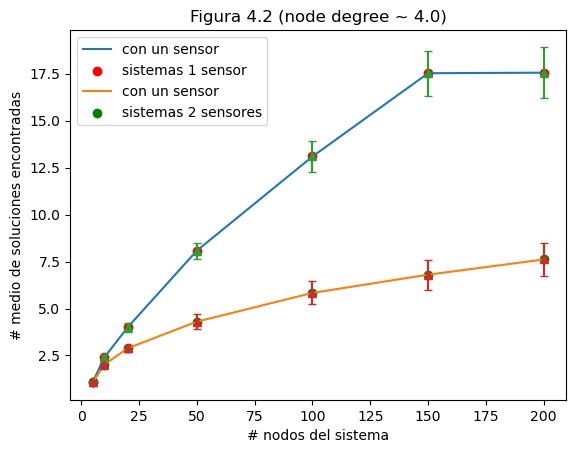

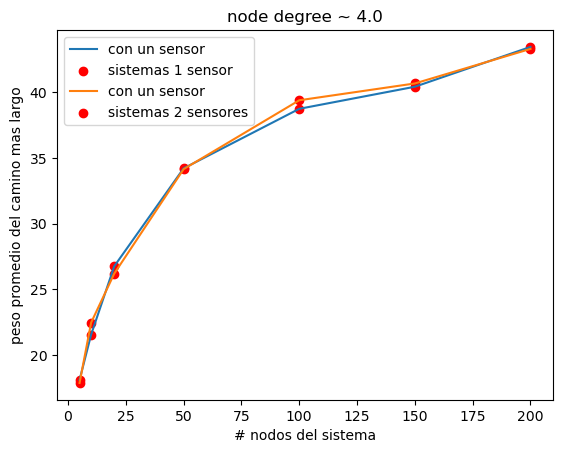

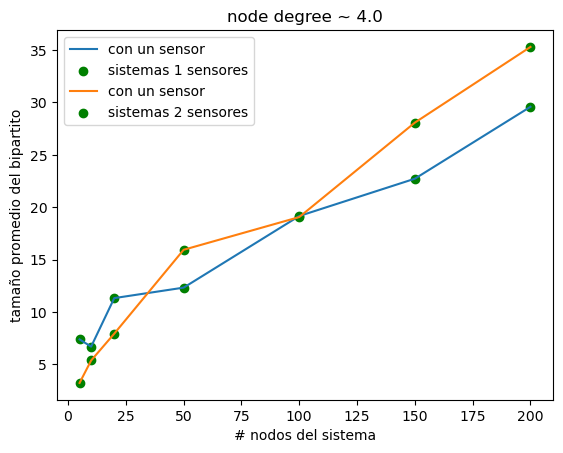

In [13]:
##Fig 4.2 con 1 y 2 sensores:
n_medio_sol_1_sensor = [1.09, 2.4, 3.99, 8.08, 13.09, 17.52, 17.55]
e_medio_1_sensor = [0.03, 0.13, 0.23, 0.43, 0.83, 1.20, 1.37]

n_medio_sol_2_sensor = [1.07, 2.01, 2.88, 4.3, 5.83, 6.8, 7.61]
e_medio_2_sensor = [0.03, 0.10, 0.20, 0.39, 0.61, 0.79, 0.90]

plt.plot(numero_de_nodos, n_medio_sol_1_sensor, label='con un sensor')
plt.scatter(numero_de_nodos, n_medio_sol_1_sensor, c='r', label='sistemas 1 sensor')
plt.plot(numero_de_nodos, n_medio_sol_2_sensor, label='con un sensor')
plt.scatter(numero_de_nodos, n_medio_sol_2_sensor, c='g', label='sistemas 2 sensores')

plt.errorbar(numero_de_nodos, n_medio_sol_1_sensor, e_medio_1_sensor, linestyle='None', marker='^', capsize=3)
plt.errorbar(numero_de_nodos, n_medio_sol_2_sensor, e_medio_2_sensor, linestyle='None', marker='^', capsize=3)

plt.xlabel("# nodos del sistema")
plt.ylabel("# medio de soluciones encontradas")
plt.title('Figura 4.2 (node degree ~ 4.0)')
plt.legend()
plt.show()

##Plot de tamaño de bipartito y de camino mas largo con 1 y 2 sensores:
camin1 = [18.11, 21.56, 26.76, 34.21, 38.74, 40.42, 43.45]
tamaÑ1 = [7.39, 6.7, 11.33, 12.33, 19.16, 22.72, 29.58]
camin2 = [17.88, 22.47, 26.2, 34.15, 39.39, 40.67, 43.3]
tamaÑ2 = [3.24, 5.38, 7.94, 15.94, 19.06, 28.07, 35.29]

plt.plot(numero_de_nodos, camin1, label='con un sensor')
plt.scatter(numero_de_nodos, camin1, c='r', label='sistemas 1 sensor')
plt.plot(numero_de_nodos, camin2, label='con un sensor')
plt.scatter(numero_de_nodos, camin2, c='r', label='sistemas 2 sensores')
plt.xlabel("# nodos del sistema")
plt.ylabel("peso promedio del camino mas largo")
plt.title('node degree ~ 4.0')
plt.legend()
plt.show()

plt.plot(numero_de_nodos, tamaÑ1, label='con un sensor')
plt.scatter(numero_de_nodos, tamaÑ1, c='g', label='sistemas 1 sensores')
plt.plot(numero_de_nodos, tamaÑ2, label='con un sensor')
plt.scatter(numero_de_nodos, tamaÑ2, c='g', label='sistemas 2 sensores')
plt.xlabel("# nodos del sistema")
plt.ylabel("tamaño promedio del bipartito")
plt.title('node degree ~ 4.0')
plt.legend()
plt.show()